In [10]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import time
import scipy.integrate as integr

In [11]:
import InbeddingDiagramDNeg as Dia
import WormholeRayTracer as w
import WormholeGraphics as wg
import Symplectic_DNeg as Smpl

In [12]:
path = os.getcwd()

In [13]:
Par = [0.8/1.42953, 8.6*2/3, 4.3*2/3] # M, rho, a parameters wormhole

initial_q = np.array([12, np.pi, np.pi/2])

In [23]:
print(Par, initial_q)
Grid_dimension = '3D'
mode = 0
Motion1, Grid1, CM1 = w.Simulate_DNeg(Smpl.Sympl_DNeg, Par, 0.05, 2000, initial_q, 20**2, 20**2, Grid_dimension, mode, wg.Grid_constr_3D_Sph)

[0.5596244919658909, 5.733333333333333, 2.8666666666666667] [12.          3.14159265  1.57079633]
183.77456712722778


In [24]:
Cosyst =  ' Sph '
cv2.imwrite(os.path.join(path, "Pictures/Image "+Grid_dimension+"Gr"+Cosyst+"DNeg Sympl"+str(Par)+" "+str(initial_q)+".png"),
            255*wg.Make_Pict_RGBP(Motion1[-1, 1], Grid1))

True

In [25]:
cv2.imwrite(os.path.join(path, "Pictures/Image "+"2DGr DNeg Sympl"+str(Par)+" "+str(initial_q)+".png"),
            255*wg.Make_Pict_RGBP(Motion1[-1, 1], wg.Grid_constr_2D(Motion1[-1, 1], 11, 1, 0.05)))

True

In [26]:
cv2.imwrite(os.path.join(path, "Pictures/Image "+"NoGrid DNeg Sympl"+str(Par)+" "+str(initial_q)+".png"),
            255*wg.Make_Pict_RGBP(Motion1[-1, 1], np.zeros(Motion1[-1, 1, 0].shape, dtype=bool)))

True

In [18]:
Motion2 = w.simulate_raytracer_fullpath(100, Par, initial_q, 500, 20**2, 20**2, 'RK45')

Initializing screen and calculating initial condition...
Iteration (0, 399) completed in 0.018584728240966797s.
Iteration (1, 399) completed in 0.01632094383239746s.
Iteration (2, 399) completed in 0.013559103012084961s.
Iteration (3, 399) completed in 0.013665199279785156s.
Iteration (4, 399) completed in 0.014421939849853516s.
Iteration (5, 399) completed in 0.014331817626953125s.
Iteration (6, 399) completed in 0.013805150985717773s.
Iteration (7, 399) completed in 0.015080928802490234s.
Iteration (8, 399) completed in 0.016607999801635742s.
Iteration (9, 399) completed in 0.01799321174621582s.
Iteration (10, 399) completed in 0.015558242797851562s.
Iteration (11, 399) completed in 0.013968944549560547s.
Iteration (12, 399) completed in 0.013335704803466797s.
Iteration (13, 399) completed in 0.013522863388061523s.
Iteration (14, 399) completed in 0.013386011123657227s.
Iteration (15, 399) completed in 0.013598918914794922s.
Iteration (16, 399) completed in 0.013163089752197266s.
Ite

Iteration (146, 399) completed in 0.014713048934936523s.
Iteration (147, 399) completed in 0.014447927474975586s.
Iteration (148, 399) completed in 0.014094114303588867s.
Iteration (149, 399) completed in 0.012584924697875977s.
Iteration (150, 399) completed in 0.01272892951965332s.
Iteration (151, 399) completed in 0.012299060821533203s.
Iteration (152, 399) completed in 0.012677907943725586s.
Iteration (153, 399) completed in 0.012696027755737305s.
Iteration (154, 399) completed in 0.012820005416870117s.
Iteration (155, 399) completed in 0.013132095336914062s.
Iteration (156, 399) completed in 0.012352943420410156s.
Iteration (157, 399) completed in 0.012663841247558594s.
Iteration (158, 399) completed in 0.013197183609008789s.
Iteration (159, 399) completed in 0.016050100326538086s.
Iteration (160, 399) completed in 0.013231992721557617s.
Iteration (161, 399) completed in 0.013235330581665039s.
Iteration (162, 399) completed in 0.01294088363647461s.
Iteration (163, 399) completed in

Iteration (291, 399) completed in 0.015330076217651367s.
Iteration (292, 399) completed in 0.015194892883300781s.
Iteration (293, 399) completed in 0.014949798583984375s.
Iteration (294, 399) completed in 0.014450311660766602s.
Iteration (295, 399) completed in 0.013863801956176758s.
Iteration (296, 399) completed in 0.014773845672607422s.
Iteration (297, 399) completed in 0.013094186782836914s.
Iteration (298, 399) completed in 0.014243125915527344s.
Iteration (299, 399) completed in 0.013924837112426758s.
Iteration (300, 399) completed in 0.01520085334777832s.
Iteration (301, 399) completed in 0.02003002166748047s.
Iteration (302, 399) completed in 0.014694929122924805s.
Iteration (303, 399) completed in 0.014922857284545898s.
Iteration (304, 399) completed in 0.015095949172973633s.
Iteration (305, 399) completed in 0.015383005142211914s.
Iteration (306, 399) completed in 0.015336036682128906s.
Iteration (307, 399) completed in 0.014678001403808594s.
Iteration (308, 399) completed in

In [21]:
cv2.imwrite(os.path.join(path, "Pictures/Image "+"2DGr DNeg Scipy RK45"+str(Par)+" "+str(initial_q)+".png"),
            255*wg.Make_Pict_RGBP(Motion2[-1, 1], wg.Grid_constr_2D(Motion2[-1, 1], 11, 1, 0.05)))

True

In [22]:
cv2.imwrite(os.path.join(path, "Pictures/Image "+"NoGrid DNeg scipy RK45"+str(Par)+" "+str(initial_q)+".png"),
            255*wg.Make_Pict_RGBP(Motion2[-1, 1], np.zeros(Motion2[-1, 1, 0].shape, dtype=bool)))

True

In [ ]:
q_scipy_symm = w.wormhole_with_symmetry2(100, Par, initial_q, 20**2, 20**2)

In [ ]:
cv2.imwrite(os.path.join(path, "Pictures/Image "+"2DGr NewSymm DNeg Scipy intgr."+str(Par)+" "+str(initial_q)+".png"),
            255*wg.Make_Pict_RGBP(q_scipy_symm, wg.Grid_constr_2D(q_scipy_symm, 11, 1, 0.05)))

In [ ]:
M = alpha.size
q_flat = np.empty((3,M))
alpha = alpha.flatten().reshape(M,1)
r_polar = r_polar.flatten().reshape(M,1)
k = np.argmin(np.abs(R.reshape(1, int(Ny/2)) - r_polar), axis=1)
q = np.concatenate(
            np.cos(alpha/2),
            np.sin(alpha/2)*np.tile(Rot_axis,(1,M)), axis=0
            )
for i in range(M):
    q_flat[3, i] = np.dot(rotation_quat(q[i]), q_cart[:,0,k[i]])

In [ ]:
np.array([[0,2],[1,3]]).flatten()

In [62]:
def gdsc(Motion, Par, name, path, geo_label = None, select = None, reduce = False):
    # input: Motion: 5D matrix, the elements being [p, q] with p, q as defined earlier
    #       Par: parameters wormhole
    #       Name: picture/filename
    #       Path: directory
    #       select: Give a list of 2D indices to plot only specific geodesiscs
    #       geo_label: if you're just plotting a list of geodesics (thus its elements in order time, [p,q], coordinate),
    #                   then give here a list of strings that which will be the label of your geodesics, corresponding to the order of your geodesics.
    #       reduce: if true sample geodescics uniformly
    M, rho, a = Par

    if np.any(select == None):
        if np.any(reduce == False):
            Sample = np.transpose(Motion, (1,2,3,0))
        else:
            Motion = np.transpose(Motion, (1,2,0,3,4))
            Ny, Nz =  Motion[0][0][0].shape
            Ny_s = int(np.sqrt(Nz))
            Nz_s = int(np.sqrt(Ny))

            # Samples a uniform portion of the rays for visualisation
            Sample = Motion[:, :, :, 1::Nz_s, 1::Ny_s]
            cl, ind = ray_spread(Nz_s, Ny_s)

    else:
        Motion = np.transpose(Motion, (3,4,0,1,2))
        Sample = np.transpose(
            [Motion[tuple(select[k])] for k in range(len(select))]
            , (2,3,1,0))

    p, q = Sample
    p_l, p_phi, p_th = p
    l, phi, theta = q
    # caluclates coordinates in inbedded space
    ax = plt.figure().add_subplot(projection='3d')
    r = w.dneg_r(l, M, rho, a)
    X, Y = r*np.cos(phi), r*np.sin(phi)
    
    S_l = np.linspace(np.max(l), np.min(l), len(l))
    Col_l = np.concatenate((l.T, np.expand_dims(S_l, axis=0)), axis=0).T
    Col_Z = Dia.imb_f_int(Col_l, Par)
    Z = Col_Z[:,:-1]
    S_Z0 = Col_Z[:,-1] + np.max(Z)

    if np.any(reduce == False):
        for k in range(len(Sample[0,0,0])):
            if np.any(geo_label == None):
                gl = str(select[k])
            else:
                gl = geo_label[k]
            ax.plot(X[:,k], Y[:,k], Z[:,k])
        ax.scatter(X[0,0] , Y[0,0], Z[0,0], label='camera', c = 'r')
        ax.set_title("Path of a geodesic that reduced to noise")
        ax.legend()
    else:
        for i in range(Nz_s):
            for j in range(Ny_s):
                ij = i + Nz_s*j
                cl_i =cl[ind[ij]]
                ax.plot(X[:,i,j], Y[:,i,j], Z[:,i,j], color = cl_i, alpha=0.5)
        ax.scatter(X[0,0,0] , Y[0,0,0], Z[0,0,0], label='camera', c = 'r')
        ax.set_title("Geodesics")
        ax.legend()

    # adds surface

    #S_l = np.linspace(np.max(l), np.min(l), len(l))
    S_phi = np.linspace(0, 2*np.pi, len(l))
    S_R, S_PHI = np.meshgrid(w.dneg_r(S_l, M, rho, a), S_phi) # radius is r(l)

    # tile because symmetric for rotations, undependant on phi
    # Integral for Z direction like defined in the paper
    S_Z = np.tile(S_Z0, (len(l), 1)) #z(l)
    
    S_X, S_Y = S_R*np.cos(S_PHI), S_R*np.sin(S_PHI)
    #print(S_X.shape, S_Y.shape, S_Z.shape)
    ax.plot_surface(S_X, S_Y, S_Z, cmap=plt.cm.YlGnBu_r, alpha=0.5)
    plt.tight_layout()
    # Hide grid lines
    ax.grid(False)

    # Hide axes ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    #ax.set_zlim([-5,5])
    plt.savefig(os.path.join(path, name), dpi=150)
    plt.show()

<IPython.core.display.Javascript object>


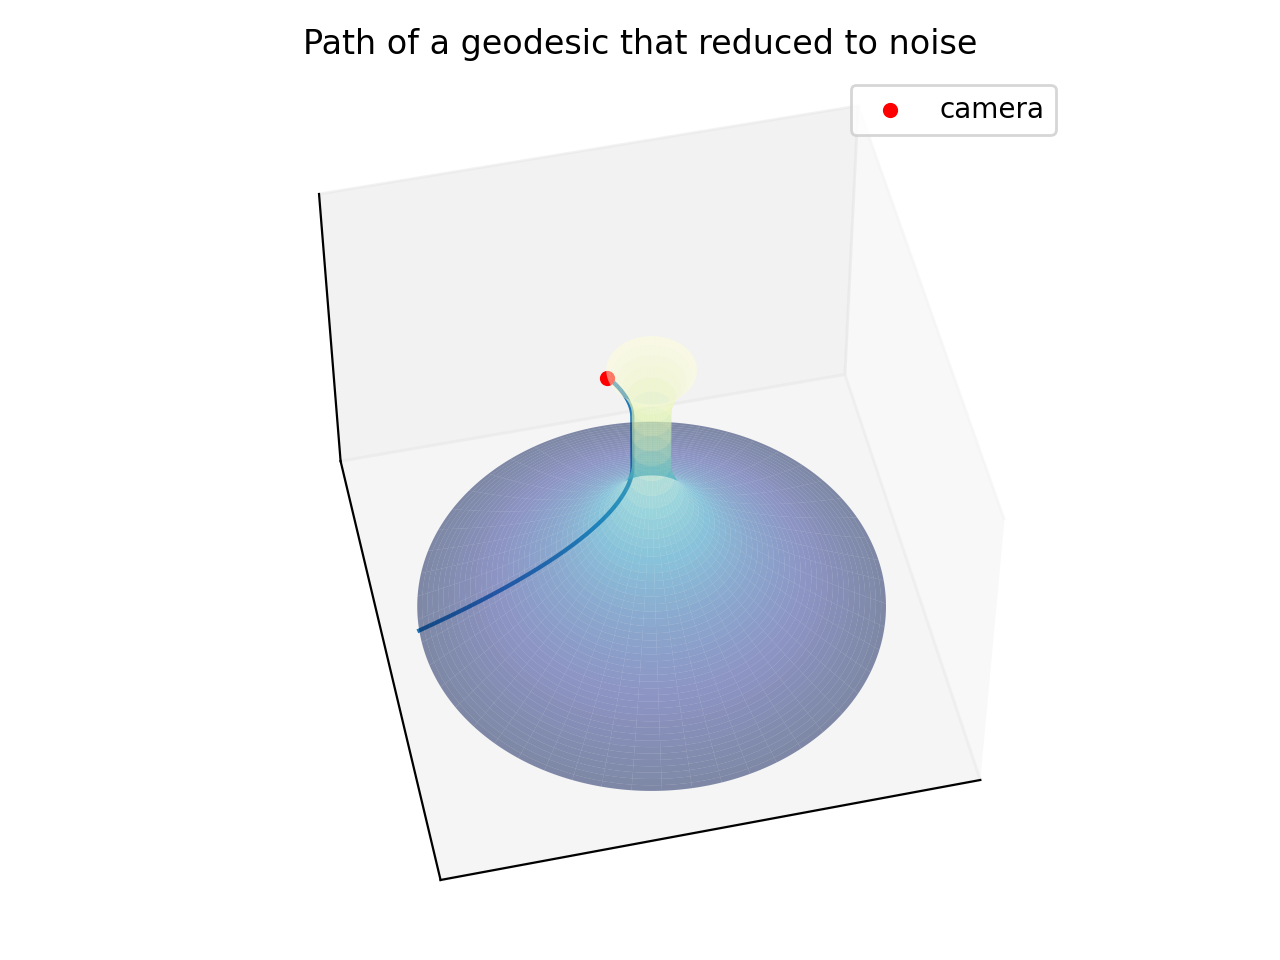

In [64]:
Geo_label = ['a', 'b', 'c', 'd']
#Geo_Sel = None
#Geo_Sel = [[20,25],[65,15],[71,58],[145,142]]
#Geo_Sel = [[68,200]] #noise symplectic [0.8/1.42953, 8.6*2/3, 4.3*2/3] [12, np.pi, np.pi/2]
Geo_sel = [[360, 199]] #noise RK [0.8/1.42953, 8.6*2/3, 4.3*2/3] [12, np.pi, np.pi/2]
if Geo_Sel == None:
    Geo_txt = ""
else:
    Geo_txt = str(Geo_Sel)
gdsc(Motion2, Par, "Pictures/Noise "+Geo_txt+" DNeg scipy RK45"+str(Par)+" "+str(initial_q)+".png", path, Geo_label, Geo_Sel)

In [ ]:
np.array(CM1).shape

In [ ]:
CM2 = np.array([w.DNeg_CM(Motion2[k,0], Motion2[k,1], Par) for k in range(len(Motion2))])

In [ ]:
wg.plot_CM(CM1, ['$H$', '$b$', '$B^{2}$'], "Pictures/CM DNeg Sympl"+str(Par)+" "+str(initial_q)+".png", path)

In [ ]:
wg.plot_CM(CM2, ['$H$', '$b$', '$B^{2}$'], "Pictures/CM DNeg scipy intgr."+str(Par)+" "+str(initial_q)+".png", path)

In [ ]:
tuple([1] + list((2,3,4)))